In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
py.rcParams['figure.figsize'] = (16, 6)
plt.hold(True)
plt.close()

from invenio_trends.etl.index_synchronizer import IndexSynchronizer
from invenio_trends.analysis.trends_detector import TrendsDetector
from invenio_trends.analysis.granularity import Granularity
from invenio_trends.analysis.utils import parse_iso_date

In [3]:
config = {
    'host': 'http://localhost:9200',
    'index': 'records-trends',
    'source_index': 'records-hep',
    'doc_type': 'hep',
    'analysis_field': 'abstracts.value',
    'date_field': 'earliest_date',
    'id_field': 'self_recid',
    'tokenizer': 'icu_tokenizer',
    'minimum_date': '2013-02-01',
    'maximum_date': None,
    'filter_script': "d = doc['earliest_date'].date; d.getDayOfYear() != 1",
    'unigram': True,
    'minimum_ngram': 2,
    'maximum_ngram': 3,
    'stopwords_file': '../invenio_trends/etl/stopwords.txt',
}

In [4]:
etl = IndexSynchronizer(config)

In [5]:
#etl.setup_index()
#etl.setup_analyzer()
#etl.setup_mappings()
#etl.synchronize()

In [6]:
td = TrendsDetector(config)

In [7]:
date = '2016-02-26T00:00:00.00'
granularity = 'day'
foreground_window = 10
background_window = 365
minimum_frequency_threshold = 5
smoothing_len = 7
num_cluster = 3
num_trends = 1000

In [8]:
reference_date = parse_iso_date(date)
gran = Granularity[granularity]
foreground_start = reference_date - foreground_window * gran.value
background_start = reference_date - background_window * gran.value
smoothing_window = np.ones(smoothing_len)

In [9]:
ids = td.interval_ids(foreground_start, reference_date)

In [10]:
ids[:10]

['0abe2369-eddb-49ff-a777-cfdba6eeb5dc',
 '5afb239a-1630-4b0d-bf1b-d66ac115b8b2',
 '8702cb36-118d-4f44-9075-75d4ddc441d3',
 '7700e3c9-b3c3-4110-b17a-30c2fccfe393',
 '9faf2f35-3ffb-4785-99f8-259190c40896',
 'b799019d-16bb-4ce1-86e6-fdc7bc1aab2e',
 '941fe2d1-eede-4693-9b58-ff6969e84a7e',
 '55efa1b0-8474-4a51-8fa4-5ae162ea41b7',
 'ea61cbe3-1133-4d52-a9f5-f6f8384598ff',
 'da019eae-5472-4d7b-a95d-52dbe240302c']

In [11]:
all_terms = td.term_vectors(ids)

In [26]:
list(all_terms.items())[0]

('decompose derive',
 {'doc_freq': 1, 'doc_total': 1, 'term_freq': 1, 'term_total': 1})

In [17]:
terms = td.sorting_freq_threshold(all_terms, minimum_frequency_threshold)

In [27]:
terms[0]

('use',
 {'doc_freq': 111, 'doc_total': 7609, 'term_freq': 594, 'term_total': 44272})

In [18]:
hists = td.terms_histograms(terms, background_start, reference_date, gran)

In [25]:
hists[0]

('use',
 {'doc_freq': 111, 'doc_total': 7609, 'term_freq': 594, 'term_total': 44272},
 (array([datetime.datetime(2015, 2, 27, 0, 0),
         datetime.datetime(2015, 2, 28, 0, 0),
         datetime.datetime(2015, 3, 1, 0, 0),
         datetime.datetime(2015, 3, 2, 0, 0),
         datetime.datetime(2015, 3, 3, 0, 0),
         datetime.datetime(2015, 3, 4, 0, 0),
         datetime.datetime(2015, 3, 5, 0, 0),
         datetime.datetime(2015, 3, 6, 0, 0),
         datetime.datetime(2015, 3, 7, 0, 0),
         datetime.datetime(2015, 3, 8, 0, 0),
         datetime.datetime(2015, 3, 9, 0, 0),
         datetime.datetime(2015, 3, 10, 0, 0),
         datetime.datetime(2015, 3, 11, 0, 0),
         datetime.datetime(2015, 3, 12, 0, 0),
         datetime.datetime(2015, 3, 13, 0, 0),
         datetime.datetime(2015, 3, 14, 0, 0),
         datetime.datetime(2015, 3, 15, 0, 0),
         datetime.datetime(2015, 3, 16, 0, 0),
         datetime.datetime(2015, 3, 17, 0, 0),
         datetime.datetime(201

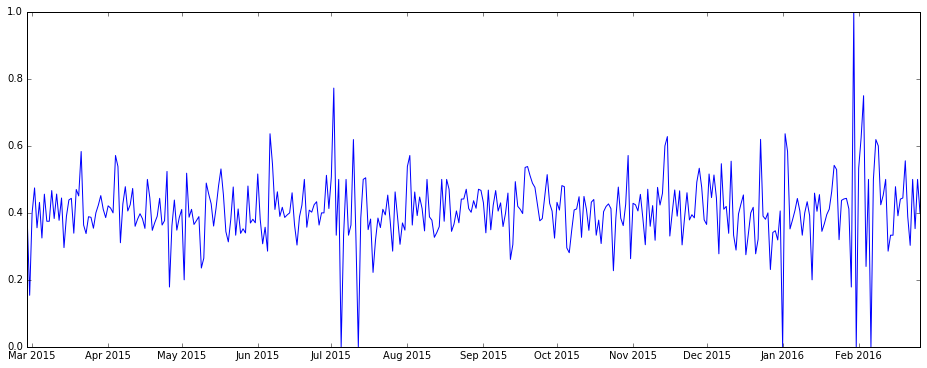

In [24]:
plt.plot(hists[0][2][0], hists[0][2][1])

In [19]:
scores = td.hist_scores(hists, foreground_start, smoothing_window)

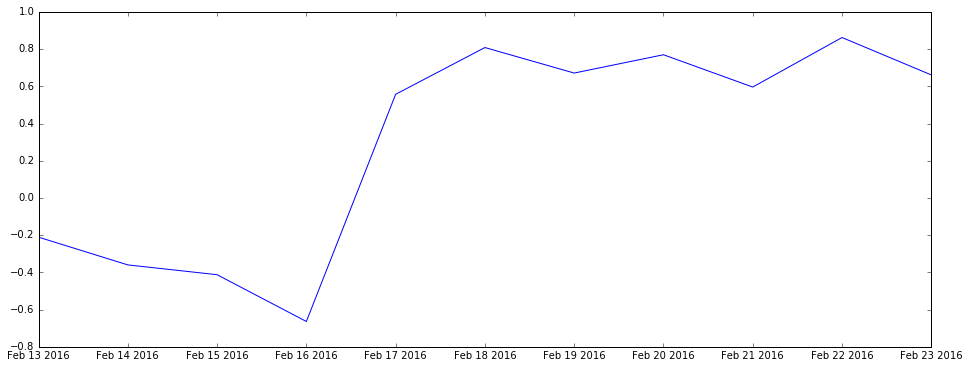

In [29]:
plt.plot(scores[0][2][0], scores[0][2][1])

In [20]:
trending = td.classify_scores(scores, num_cluster)

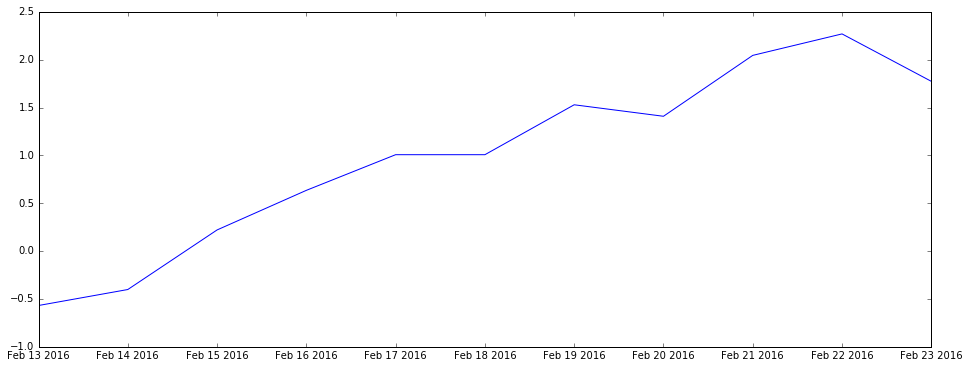

In [32]:
plt.plot(trending[0][2][0], trending[0][2][1])

In [21]:
trends = td.prune_scores(trending, num_trends)

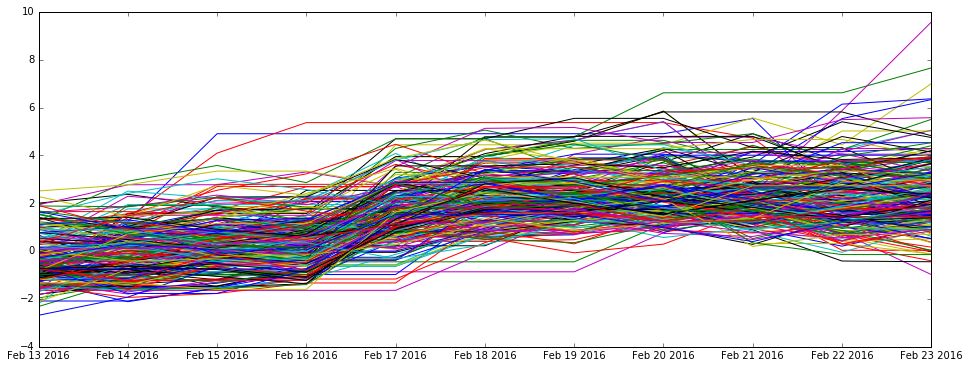

In [36]:
for term, stats, (date, score) in trends:
    plt.plot(date, score, label=term)
#plt.legend(loc='upper left')
plt.show()

In [34]:
len(trends)

227